# Online Logistic Regression using conditional moments Gaussian filter

This notebook shows how to do online (recursive) Bayesian inference of the weights of a logistic regression model using conditional moments Gaussian filter (CMGF). To do this, we treat the parameters of the model as the unknown hidden states.
We assume that these are approximately constant over time (we add a small amount of Gaussian drift, for numerical stability.)
The graphical model is shown below.

![RLS](https://github.com/probml/dynamax/blob/main/docs/figures/rlsDgm.png?raw=true)

The model has the following form

\begin{align*}
\theta_t &=  \theta_{t-1} + q_t, \; q_t \sim \mathrm{N}(0, 0.01 I)  \\
y_t &\sim \mathrm{Bern}(\sigma(\theta_t^T x_t))
\end{align*}

where $\sigma(a) = e^a /(1+e^a)$ is the logistic (aka sigmoid) function.
This is a generalized Gaussian SSM, where the observation model is non-Gaussian.

We perform approximate inference using the conditional moments Gaussian filter (CMGF).
We approximate the relevant integrals using 3 different methods: 
1. linearization (extended Kalman filter),
2. sigma point approximation (unscented kalman filter), and
3. Gauss hermite integration (order 5).
We compare results with the offline (batch) Laplace approximation, and see that GHKF converges fastest to the batch solution,
but is also slower.
For more details, see sec 8.7.7 of [Probabilistic Machine Learning: Advanced Topics](https://probml.github.io/pml-book/book2.html).


## Imports

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [126]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr

from jax.scipy.optimize import minimize

from dynamax.generalized_gaussian_ssm import ParamsGGSSM, EKFIntegrals, UKFIntegrals, GHKFIntegrals
from dynamax.generalized_gaussian_ssm import conditional_moments_gaussian_filter

## Simulation and Plotting

First, we generate a simple dataset for 2d binary classification.

In [9]:
def generate_dataset(num_points=1000, shuffle=True, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key0, key1, key2 = jr.split(key, 3)

    # Generate standardized noisy inputs that correspond to output '0'
    num_zero_points = num_points // 2
    zero_input = jnp.array([[-1., -1.]] * num_zero_points)
    zero_input += jr.normal(key0, (num_zero_points, 2))

    # Generate standardized noisy inputs that correspond to output '1'
    num_one_points = num_points - num_zero_points
    one_input = jnp.array([[1., 1.]] * num_one_points)
    one_input += jr.normal(key1, (num_one_points, 2))

    # Stack the inputs and add bias term
    X = jnp.concatenate([zero_input, one_input])
    X = jnp.concatenate([jnp.ones((num_points, 1)), X], axis=1)

    # Generate binary output
    y = jnp.concatenate([jnp.zeros((num_zero_points)), jnp.ones((num_one_points))])

    # Shuffle
    if shuffle:
        idx = jr.permutation(key2, num_points)
        X, y = X[idx], y[idx]
    
    return X, y

In [10]:
# Generate data
X, y = generate_dataset()

Let's look at our binary data in 2d.

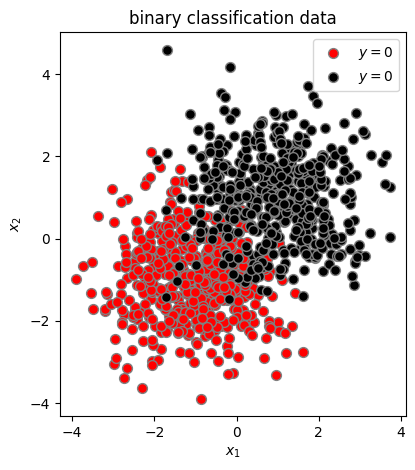

In [85]:
plt.scatter(X[y==0, 1], X[y==0, 2], c='red', s=50, edgecolors='gray', label=r'$y=0$')
plt.scatter(X[y==1, 1], X[y==1, 2], c='black', s=50, edgecolors='gray', label=r'$y=0$')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.title("binary classification data")
plt.tight_layout()
plt.gca().set_aspect('equal')

## Visualizing the posterior predictive

Next, we define functions to compute and visualize the 2d posterior predictive distribution.
Let $\mathbf{X} \in \mathbb{R}^{n \times p}$ denote the covariates of the training covariates (inputs) and $\mathbf{y} \in \{0,1\}^n$ denote the training labels (outputs). The posterior predictive probability of a new label $y'$ associated with a new covariate $x' \in \mathbb{R}^p$ is,

\begin{align*}
\Pr(y'=1 \mid x', \mathbf{X}, \mathbf{y})
&= \int \mathrm{Pr}(y'=1 \mid x', \theta) \, p(\theta \mid \mathbf{X}, \mathbf{y}) \, \mathrm{d} \theta \\
&= \int \sigma(\theta^\top x') \, p(\theta \mid \mathbf{X}, \mathbf{y}) \, \mathrm{d} \theta \\
&\approx \frac{1}{S} \sum_{s=1}^S \sigma( {\theta^{(s)}}^\top x')
\end{align*}

where

\begin{align*}
\theta^{(s)} \stackrel{\mathsf{ind}}{\sim} p(\theta \mid \mathbf{X}, \mathbf{y}).
\end{align*}

In practice, we cannot compute the posterior distribution of $\theta$ exactly, so we plug in a Gaussian approximation obtained with either the CMGF (for online infererence) or the Laplace approximation (for offline, full-batch inference).

In [86]:
def compute_posterior_predictive(lim, mean, cov, n_samples=5000, key=0):
    """
    Compute the posterior predictive distribution of the model.

    Parameters
    ----------
    lim : float
        evaluate a grid ranging from (-lim, lim) in all dimensions
    mean : array
        mean of the posterior distribution over weights
    cov : array
        covariance of the posterior distribution over weights
    n_samples : int
        number of samples to use to approximate the posterior predictive distribution
    key : int or jax.random.PRNGKey
        random key
    """
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define grid
    npts = 50
    X1, X2 = jnp.meshgrid(jnp.linspace(-lim, lim, npts), jnp.linspace(-lim, lim, npts))
    X_grid = jnp.stack([X1, X2])
    X_grid_with_bias = jnp.concatenate([jnp.ones((1, npts, npts)), X_grid])

    samples = jax.random.multivariate_normal(key, mean, cov, (n_samples,))
    E_y = jax.nn.sigmoid(jnp.einsum("mij,sm->sij", X_grid_with_bias, samples))
    E_y = E_y.mean(axis=0)
    return X_grid, E_y


def plot_posterior_predictive(X, y, 
                              w_mean=None, 
                              w_cov=None, 
                              true_w=None,
                              cmap="viridis", 
                              ax=None, 
                              ):
    """
    Plot the posterior predictive distribution of the model.

    Parameters
    ----------
    X : array
        input data
    y : array
        labels
    w_mean : array
        mean of the posterior distribution over weights
    w_cov : array
        covariance of the posterior distribution over weights
    true_w : array
        true weights
    cmap : str
        colormap
    ax : matplotlib.axes.Axes
        axes to plot on
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    if w_mean is not None and w_cov is not None:
        # Compute and show the posterior predictive distribution
        lim = 1.05 * abs(X).max()
        X_grid, E_y = compute_posterior_predictive(lim, w_mean, w_cov)
        im = ax.contourf(*X_grid, E_y, cmap=cmap, levels=jnp.linspace(0, 1, 21))
        plt.colorbar(im, label="posterior predictive probability", ticks=[0, 0.25, 0.5, 0.75, 1])
    
    # Scatter plot the data
    ax.scatter(X[y==0, 1], X[y==0, 2], c='red', edgecolors='gray', s=50, label=r"$y=0$")
    ax.scatter(X[y==1, 1], X[y==1, 2], c='black', edgecolors='gray', s=50, label=r"$y=1$")

    # Compute the true decision boundary
    if true_w is not None:
        x1 = X_grid[0]
        x2 = -true_w[1]/true_w[2] * x1 - true_w[0]/true_w[2]
        ax.plot(x1, x2, 'k--', label='true boundary')

    ax.set_aspect('equal')
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    plt.legend()
    plt.tight_layout()
    return ax

## Offline inference with the Laplace approximation

We use the Laplace approximation to compute an approximate posterior given all the data (i.e., an offline estimate),

\begin{align*}
p(\theta \mid \mathbf{X}, \mathbf{y})
&\approx 
\mathrm{N}(\theta \mid \mu, \Sigma)
\end{align*}

where

\begin{align*}
\mu &= \arg \max_\theta \mathcal{L}(\theta) \\
\mathcal{L}(\theta) &= \sum_{i=1}^n \log p(y_i \mid x_i, \theta) + \log p(\theta)
\end{align*}

is the _maximum a posteriori_ (MAP) estimate of the parameters and 

\begin{align*}
\Sigma &= - [\nabla^2 \mathcal{L}(\theta)|_{\theta = \mu}]^{-1}
\end{align*}

is the negative inverse Hessian around the MAP estimate.

In [91]:
def log_joint(w, X, y, prior_var):
    prediction = jax.nn.sigmoid(X @ w)
    log_prior = -(prior_var * w @ w / 2)
    log_likelihood = y * jnp.log(prediction) + (1 - y) * jnp.log(1 - prediction)
    return log_prior + log_likelihood.sum()

def laplace_inference(X, y, prior_var=2.0, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    input_dim = X.shape[-1]

    # Initial random guess
    w0 = jr.multivariate_normal(key, jnp.zeros(input_dim), jnp.eye(input_dim) * prior_var)
    
    # Energy function to minimize
    E = lambda w: -log_joint(w, X, y, prior_var) / len(y)

    # Find the MAP estimate and the Hessian around that point
    w_laplace = minimize(E, w0, method="BFGS").x
    cov_laplace = jax.hessian(E)(w_laplace)
    return w_laplace, cov_laplace

In [92]:
# Compute Laplace posterior
prior_var = 1.0
w_mean_laplace, w_cov_laplace = laplace_inference(X, y, prior_var=prior_var)

Text(0.5, 1.0, 'Posterior predictive with Laplace approximation')

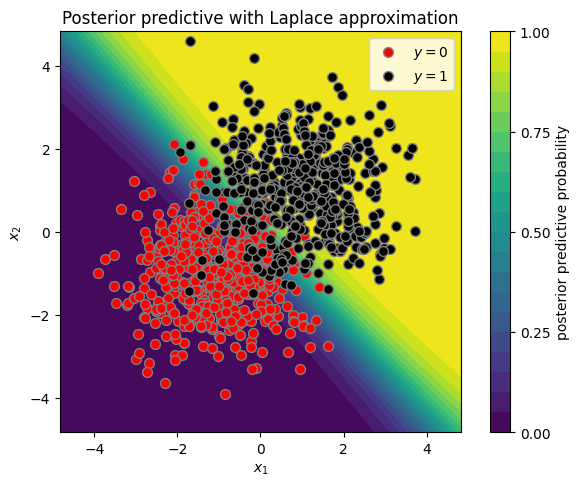

In [93]:
plot_posterior_predictive(X, y, w_mean_laplace, w_cov_laplace)
plt.title("Posterior predictive with Laplace approximation")

## Online inference with CMGF

Now, let's use the conditional moments Gaussian filter (CMGF) to estimate the posterior in online fashion, one data point at a time. As described above, we formulate the online inference problem as filtering in a nonlinear Gaussian model where the latent states are the parameters of the model.

### Helper function for plotting

The function below plots the convergence of filtered estimates compared to the offline Laplace estimate.

In [195]:
def plot_online_inference(w_means, 
                          w_covs, 
                          w_mean_offline,
                          step=20):
    """
    Plot the online inference of the weights.

    Parameters
    ----------
    w_means : array
        means of the weights at each time step
    w_covs : array
        covariances of the weights at each time step
    w_mean_offline : array
        offline estimate of the weights
    """
    n_datapoints, input_dim = w_means.shape
    assert input_dim == 3, "Only works for 3D weights"
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    w_stds = jnp.sqrt(jax.vmap(jnp.diag)(w_covs))
    ts = jnp.arange(n_datapoints) + 1
    inds = jnp.concatenate([jnp.arange(0, n_datapoints, step), 
                            jnp.array([n_datapoints - 1])])
    assert w_stds.shape == (n_datapoints, input_dim)
    
    for i in range(input_dim):
        axs[i].errorbar(ts[inds], w_means[inds, i], w_stds[inds, i], label=f"online")
        axs[i].axhline(y=w_mean_offline[i], ls=":", color='k', label=f"offline")
        axs[i].set_ylabel(rf"$w_{i}$")
        axs[i].set_xlim(1, n_datapoints)
        axs[i].set_xlabel("ordered sample number")
        if i == input_dim - 1:
            axs[i].legend(loc="lower right")
    plt.tight_layout()
    return fig, axs

### Set up the CMGF Parameters

In [196]:
input_dim = X.shape[-1]
state_dim = input_dim # linear model
sigmoid_fn = lambda w, x: jax.nn.sigmoid(w @ x)

# Initial parameters for all CMGF methods
initial_mean, initial_covariance = jnp.zeros(state_dim), prior_var * jnp.eye(state_dim)
dynamics_function = lambda w, x: w
dynamics_covariance = 1e-8 * jnp.eye(state_dim)
emission_mean_function = sigmoid_fn
emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

cmgf_params = ParamsGGSSM(
    initial_mean = initial_mean,
    initial_covariance = initial_covariance,
    dynamics_function = dynamics_function,
    dynamics_covariance = dynamics_covariance,
    emission_mean_function = emission_mean_function,
    emission_cov_function = emission_cov_function
)

### Run the CMGF using the EKF-style integral approximations

To run the CMGF, we also need to specify how we approximate the non-Gaussian integrals. First, we use an EKF-style approximation based on a first-order Taylor approximation of the nonlinear emission function.

In [197]:
# Run CMGF-EKF and extract final estimates for moments
ekf_post = conditional_moments_gaussian_filter(cmgf_params, EKFIntegrals(), y, inputs=X)
ekf_means, ekf_covs = ekf_post.filtered_means, ekf_post.filtered_covariances

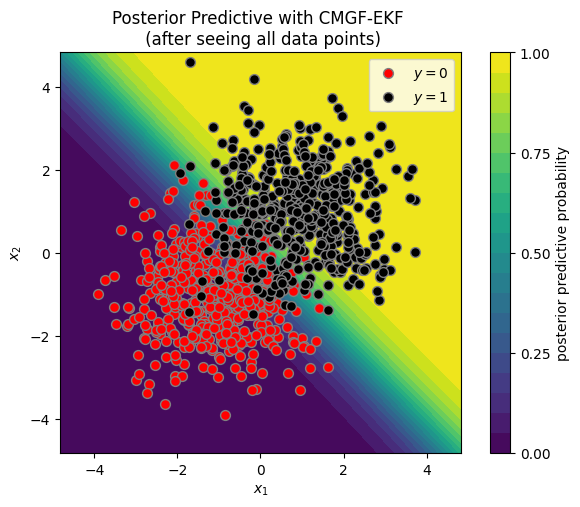

In [198]:
# Plot posterior predictive distribution
plot_posterior_predictive(X, y, ekf_means[-1], ekf_covs[-1])
_ = plt.title("Posterior Predictive with CMGF-EKF \n (after seeing all data points)")


Text(0.5, 1.05, 'Online inference of weights with CMGF-EKF')

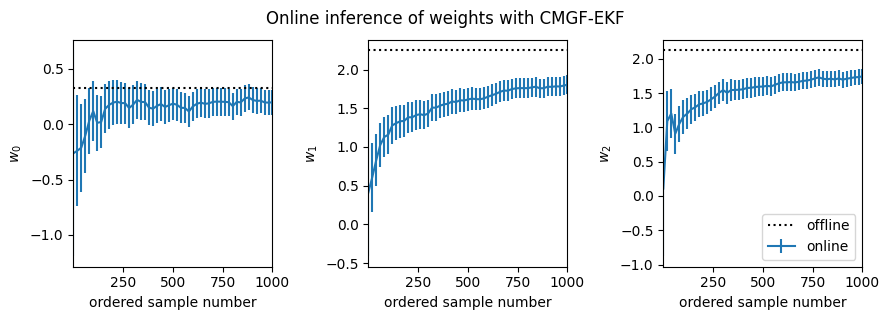

In [199]:
fig, _ = plot_online_inference(ekf_means, ekf_covs, w_mean_laplace)
fig.suptitle("Online inference of weights with CMGF-EKF", y=1.05)

### Run the CMGF using the UKF-style integral approximations

Next we use a UKF-style approximation based on a sigma-point approximation of the nonlinear emission function.

In [200]:
# Run CMGF-UKF and extract final estimates for moments
ukf_post = conditional_moments_gaussian_filter(cmgf_params, UKFIntegrals(), y, inputs=X)
ukf_means, ukf_covs = ukf_post.filtered_means, ukf_post.filtered_covariances

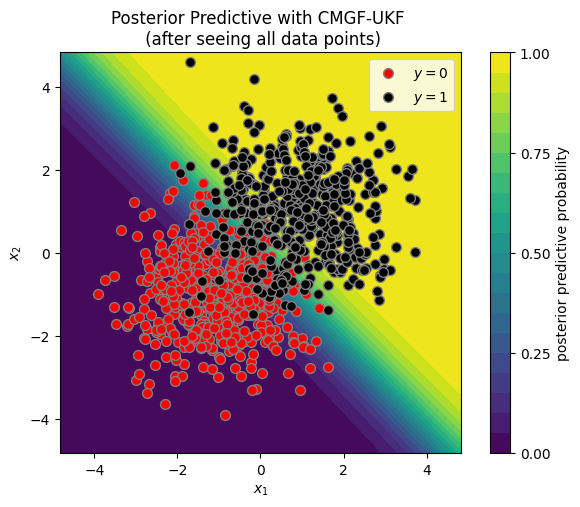

In [201]:
# Plot posterior predictive distribution
plot_posterior_predictive(X, y, ukf_means[-1], ukf_covs[-1])
_ = plt.title("Posterior Predictive with CMGF-UKF \n (after seeing all data points)")


Text(0.5, 1.05, 'Online inference of weights with CMGF-UKF')

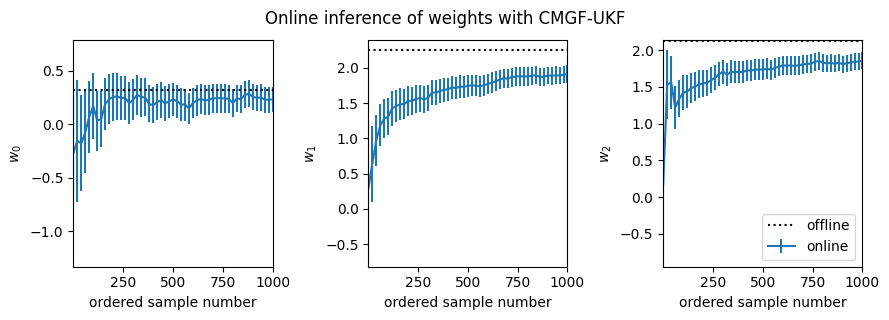

In [202]:
fig, _ = plot_online_inference(ukf_means, ukf_covs, w_mean_laplace)
fig.suptitle("Online inference of weights with CMGF-UKF", y=1.05)

### GHKF

Finally, run the CMGF using Gauss-Hermite quadrature to approximate the integrals.

In [203]:
# Run CMGF-GHKF and extract final estimates for moments
ghkf_post = conditional_moments_gaussian_filter(cmgf_params, GHKFIntegrals(order=5), y, inputs=X)
ghkf_means, ghkf_covs = ghkf_post.filtered_means, ghkf_post.filtered_covariances

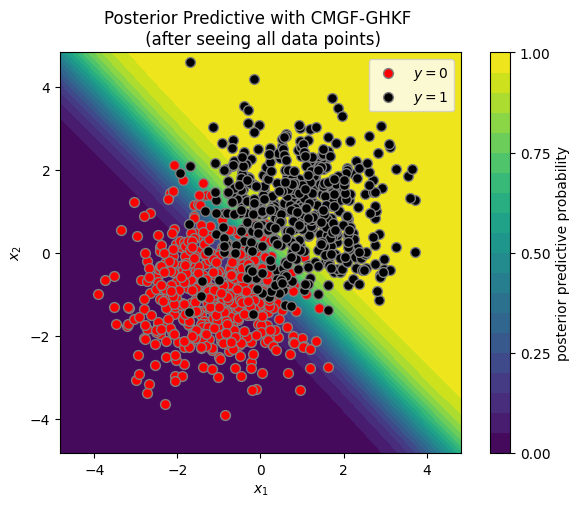

In [204]:
# Plot posterior predictive distribution
plot_posterior_predictive(X, y, ghkf_means[-1], ghkf_covs[-1])
_ = plt.title("Posterior Predictive with CMGF-GHKF \n (after seeing all data points)")


Text(0.5, 1.05, 'Online inference of weights with CMGF-GHKF')

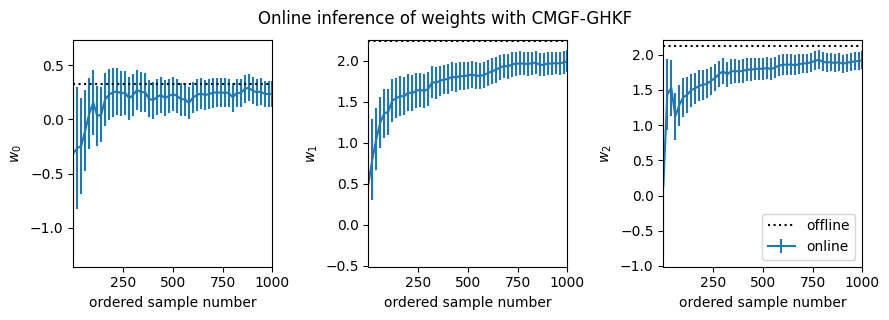

In [205]:
fig, _ = plot_online_inference(ghkf_means, ghkf_covs, w_mean_laplace)
fig.suptitle("Online inference of weights with CMGF-GHKF", y=1.05)

## Conclusion

This notebook demonstrates how to use a conditional moments Gaussian filter (CMGF) to perform online approximate inference of the weights of a logistic regression model. You can choose different methods of approximating the integrals inside the CMGF, and here it looks like the Gauss-Hermite quadrature rule yields a filter that best approximates the offline posterior estimate. 

In all cases, it appears the online estimates slightly underestimate the magnitude of the true weights. This bias likely arises from an accumulation of errors since the online algorithms iteratively approximate the filtering distributions as Gaussian at each time point, whereas the Laplace approximation forms a Gaussian approximation to the full posterior. It appears that the UKF and Gauss-Hermite integral approximations are slightly better than the EKF in this regard.

Overall, this notebook shows how straightforward it is to perform these challenging inference tasks using Dynamax!